# MAML reimplementation using TensorFlow 2.0

Reproduction of MAML using TensorFlow 2.0.

This  is highly influenced by the pytorch reproduction by Adrien Lucas Effot: [Paper repro: Deep Metalearning using “MAML” and “Reptile”](https://towardsdatascience.com/paper-repro-deep-metalearning-using-maml-and-reptile-fd1df1cc81b0)

Github: [https://github.com/mari-linhares/tensorflow-maml](https://github.com/mari-linhares/tensorflow-maml)

Twitter: [@hereismari](https://twitter.com/hereismari)

## MAML paper

https://arxiv.org/abs/1703.03400

**Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks**
*Chelsea Finn, Pieter Abbeel, Sergey Levine*

> We propose an algorithm for meta-learning that is model-agnostic, in the sense that it is compatible with any model trained with gradient descent and applicable to a variety of different learning problems, including classification, regression, and reinforcement learning. The goal of meta-learning is to train a model on a variety of learning tasks, such that it can solve new learning tasks using only a small number of training samples. In our approach, the parameters of the model are explicitly trained such that a small number of gradient steps with a small amount of training data from a new task will produce good generalization performance on that task. In effect, our method trains the model to be easy to fine-tune. We demonstrate that this approach leads to state-of-the-art performance on two few-shot image classification benchmarks, produces good results on few-shot regression, and accelerates fine-tuning for policy gradient reinforcement learning with neural network policies.

---

![image.png](https://cdn-images-1.medium.com/max/1600/1*EUt0H5AOEFkERg-OzfCC7A.png)


### TensorFlow installation

In [46]:
# !pip install -q tensorflow-gpu==2.0.0-alpha0  #for colab run

### Imports

In [47]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import tensorflow.keras.backend as keras_backend
from tensorflow import keras
tf.keras.backend.set_floatx('float64')
# Other dependencies
import random
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])
import matplotlib as mpl
# mpl.style.use('seaborn')
# from colorama import Fore
# Reproduction
np.random.seed(333)


print('Python version: ', sys.version)
print('TensorFlow version: ', tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('GPU found at: {}'.format(device_name))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python version:  3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
TensorFlow version:  2.0.0
GPU found at: /device:GPU:0


In [74]:
# import functions for run

import model, train, train_maml
from sine_generator import SinusoidGenerator 
import generate_dataset, shuffled_batch 
from eval_sinewave_for_test import eval_sinewave_for_test
from  plot_model_comparison_to_average import plot_model_comparison_to_average
from  compare_maml_and_neural_net import compare_maml_and_neural_net
from save_model_weight import save_model_weight
from load_model_weight import load_model_weight 

colors = {0:'dodgerblue' , 1: 'tomato' , 2:'forestgreen'}

## Section 5.1 Evaluating MAML on regression

> *We start with a simple regression problem that illustrates
the basic principles of MAML. Each task involves regressing
from the input to the output of a sine wave, where the
amplitude and phase of the sinusoid are varied between
tasks. Thus, p(T ) is continuous, where the amplitude
varies within [0.1, 5.0] and the phase varies within [0, π],
and the input and output both have a dimensionality of 1.
During training and testing, datapoints x are sampled uniformly
from [−5.0, 5.0].*

![]()

# Sinusoid Generator

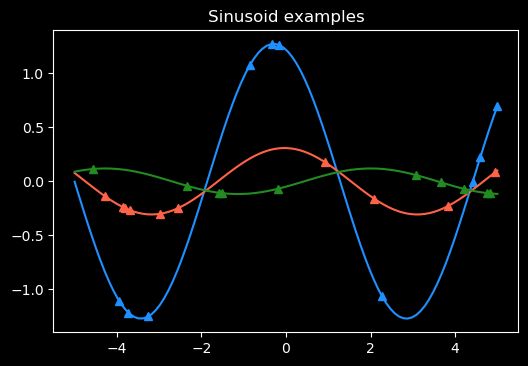

In [49]:
sine_generator = SinusoidGenerator(K=10)

fig = plt.figure(figsize=(6,4), dpi=100)
for i in range(3):

    sine_generator.plot(SinusoidGenerator(K=10), fig, title='Sinusoid examples', color=colors[i])


# Generate sinusoid datasets


In [50]:
train_ds, test_ds = generate_dataset.generate_dataset(K=10, test_size=25)
# num_batches = len(train_ds)
train_ds[0]

# Average test dataset

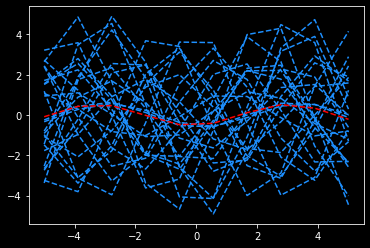

In [51]:
ts_ds = test_ds
# tr_ds, ts_ds = generate_dataset(K=10, test_size=25)
avg_pred =[]
x, _ = SinusoidGenerator(K=10).equally_spaced_samples()  
for i, sinusoid_generator in enumerate(ts_ds):
        _ , y = sinusoid_generator.equally_spaced_samples()
        plt.plot(x, y,'--', color=colors[0])
        avg_pred.append(y)
avg_plot, = plt.plot(x, np.mean(avg_pred, axis=0),'--', color='red')
plt.show()

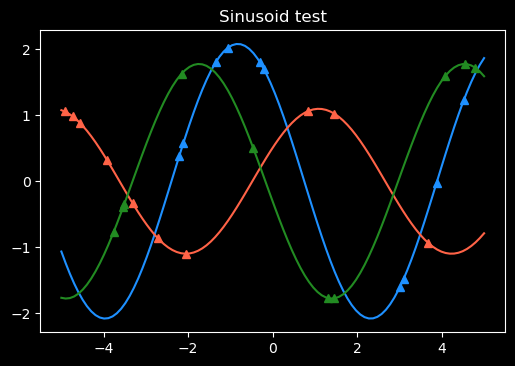

In [52]:
fig = plt.figure(figsize=(6,4), dpi=100)
for i in range(3):

    sine_generator.plot(test_ds[i], fig, title='Sinusoid test', color=colors[i])


# Training a regular Neural Network

We're training a Neural Network for given a batch of size *K* of randomly sampled values (*x*) predict *f(x)* where f is a sine wave function with amplitude randomly sampled within [0.1, 5.0] and the phase randomly sampled within [-π, π].

# Model definition


> *The regressor
is a neural network model with 2 hidden layers of size
40 with ReLU nonlinearities.*

In [53]:
from model import SineModel

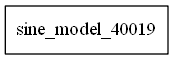

In [54]:
import graphviz
import pydotplus
pydotplus.find_graphviz()
keras.utils.plot_model(SineModel(), show_shapes=True, to_file='model.png')

# Train 

Step 0: loss = 2.116917922730926, Time to run 1000 steps = 5.13 seconds
Step 1000: loss = 4.112755949592717, Time to run 1000 steps = 10.35 seconds
Step 2000: loss = 4.173564934383829, Time to run 1000 steps = 9.72 seconds
Step 3000: loss = 4.167835861606154, Time to run 1000 steps = 9.55 seconds
Step 4000: loss = 4.165598824654542, Time to run 1000 steps = 9.31 seconds
Step 5000: loss = 4.178997238921212, Time to run 1000 steps = 10.55 seconds
Step 6000: loss = 4.1986574545846285, Time to run 1000 steps = 10.26 seconds
Step 7000: loss = 4.194273142780493, Time to run 1000 steps = 10.81 seconds
Step 8000: loss = 4.207395698175542, Time to run 1000 steps = 10.22 seconds
Step 9000: loss = 4.212085913306627, Time to run 1000 steps = 10.31 seconds
Step 10000: loss = 4.21544254552638, Time to run 1000 steps = 9.56 seconds
Step 11000: loss = 4.226051727491717, Time to run 1000 steps = 9.87 seconds
Step 12000: loss = 4.234843163771783, Time to run 1000 steps = 9.06 seconds
Step 13000: loss = 

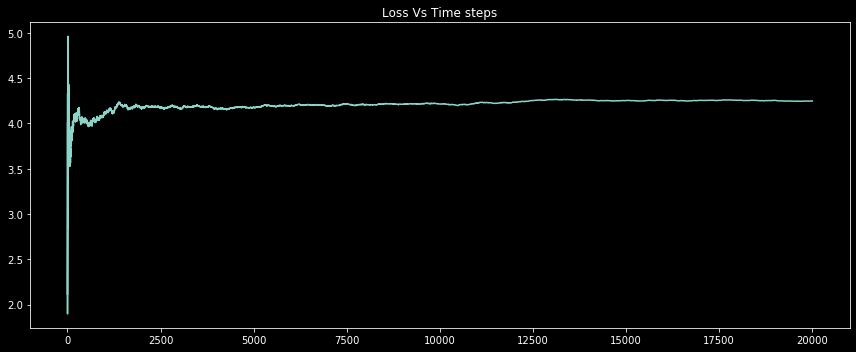

In [55]:
sine_model = SineModel()
neural_net = train.train_model(sine_model, train_ds)
# neural_net = train.train_model_shuffled(train_ds)

### A neural network trained for this task, should converge to the average of the sinusoids curves.

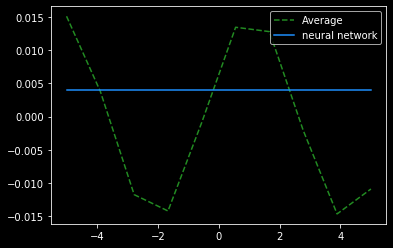

In [56]:
plot_model_comparison_to_average(model=neural_net, ds=train_ds)

### Transfer learning?

Here we try to use the trained neural network to initialize the weights for a model trained on new sine wave functions.

The new sine wave is treated as a new task. Our model was trained on a bunch of sine wave tasks and we're trying to use this previous knowledge to initialize the weights of the model for a new task.

### Try to use transfer learning for different sine waves

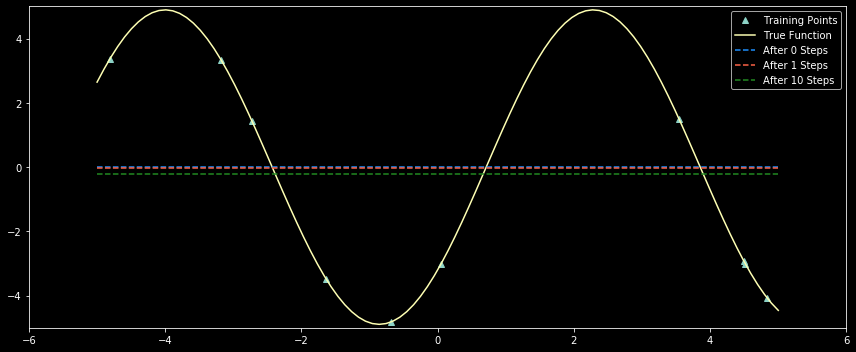

In [57]:
for index in np.random.choice(len(test_ds), size=1, replace=False):
    fit_res, w3_copied_model = eval_sinewave_for_test(neural_net, test_ds[index])

### MAML

![](https://cdn-images-1.medium.com/max/1600/1*_pgbRGIlmCRsYNBHl71mUA.png)

## Training MAML

It should take around 40 seconds to train for 1000 steps.

In [58]:
sine_model = SineModel()
maml = train_maml.train_maml(sine_model, 1, train_ds)

Step 1000: loss = 4.018056718963995, Time to run 1000 steps = 57.5106418132782
Step 2000: loss = 3.9688745311338205, Time to run 1000 steps = 56.85678172111511
Step 3000: loss = 3.9390391307275316, Time to run 1000 steps = 55.3426251411438
Step 4000: loss = 3.9219885403064314, Time to run 1000 steps = 54.98406004905701
Step 5000: loss = 3.7964441192797613, Time to run 1000 steps = 56.40477180480957
Step 6000: loss = 3.6076964098606283, Time to run 1000 steps = 54.892308712005615
Step 7000: loss = 3.4154850095387026, Time to run 1000 steps = 55.679177045822144
Step 8000: loss = 3.2659464451655076, Time to run 1000 steps = 53.838122606277466
Step 9000: loss = 3.130898938180588, Time to run 1000 steps = 55.2383828163147
Step 10000: loss = 2.9957320033069457, Time to run 1000 steps = 58.86449074745178
Step 11000: loss = 2.897634693001413, Time to run 1000 steps = 54.0974326133728
Step 12000: loss = 2.8154646448259606, Time to run 1000 steps = 55.551578760147095
Step 13000: loss = 2.7304515

##  MAML model: compare average


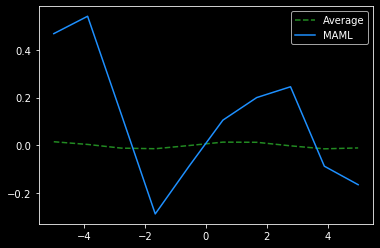

In [59]:
plot_model_comparison_to_average(maml, train_ds, model_name='MAML')

# Use MAML model to fit new sine wave

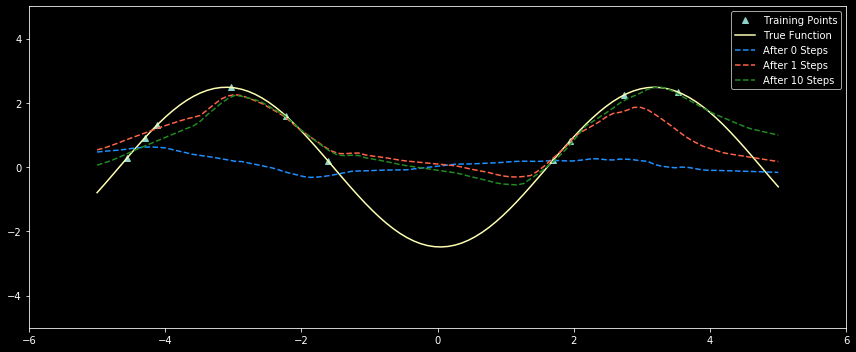

In [71]:
for index in np.random.choice(len(test_ds), size=1, replace=False):
    eval_sinewave_for_test(maml, test_ds[index])

# Save Model

In [61]:
save_model_weight(neural_net, path="./net/neural_net_model")
save_model_weight(maml, path="./maml/maml_model")

# Load Model

In [73]:
sinusoid_generator = SinusoidGenerator(K=10)
x, _ = sinusoid_generator.batch()
neural_net = load_model_weight(SineModel(), path="./net/neural_net_model", x=x)
maml = load_model_weight(SineModel(), path="./maml/maml_model", x=x)

print(neural_net.out.get_weights()[0].shape)
print(maml.out.get_weights()[0].shape)

(40, 1)
(40, 1)


# MAML vs Regular Neural Network

MAML


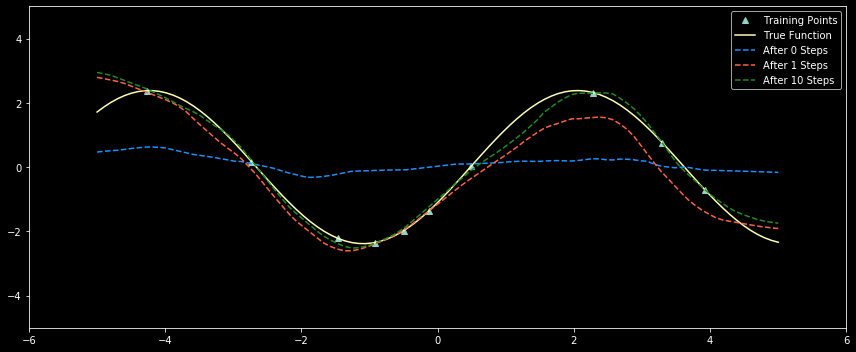

Neural Net


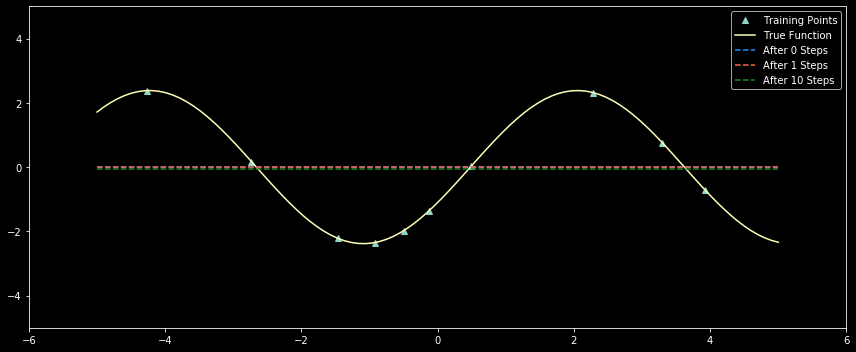

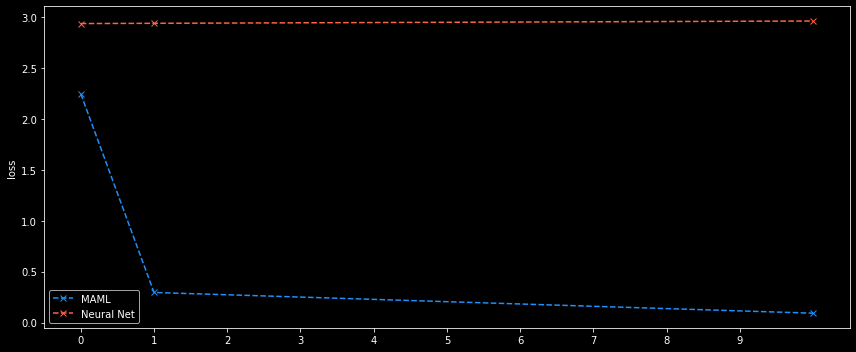

In [63]:
for _ in range(1):
    index = np.random.choice(range(len(test_ds)))
    w3_maml_model, w3_net_model = compare_maml_and_neural_net(maml, neural_net, test_ds[index])

## weights of last layer of  models during fine-tuning

In [64]:
for i in range(len(w3_maml_model)):
    print(f'regular {i+1}:\n {w3_net_model[i]}, \nmaml {i+1}:\n{w3_maml_model[i]}')

regular 1:
 [[-2.26422462e-01]
 [ 3.15548797e-01]
 [ 4.71225043e-02]
 [-1.05756512e-02]
 [ 3.45126959e-04]
 [ 1.01409718e-01]
 [-1.58872847e-01]
 [-9.21971323e-02]
 [-1.36678230e-02]
 [-5.23611750e-02]
 [ 2.03296411e-04]
 [ 4.69504192e-02]
 [ 4.95054509e-02]
 [-1.82198098e-01]
 [ 1.70277432e-02]
 [ 3.11014479e-01]
 [-2.24632884e-01]
 [ 1.70937617e-01]
 [-1.18279907e-01]
 [ 2.21599097e-01]
 [-1.62286469e-02]
 [-3.24169538e-02]
 [-1.37922635e-02]
 [-4.72005110e-02]
 [ 2.11103207e-01]
 [ 1.34129435e-01]
 [-5.52768287e-02]
 [ 2.89479152e-01]
 [ 4.83618887e-02]
 [ 9.15804200e-02]
 [-3.20409112e-01]
 [-9.26264150e-02]
 [ 1.84734773e-01]
 [ 7.00020920e-02]
 [-1.56955526e-01]
 [ 1.78678623e-01]
 [ 3.72800747e-02]
 [ 1.72730695e-01]
 [-1.24366207e-01]
 [ 1.25795772e-01]], 
maml 1:
[[ 1.2415018 ]
 [-0.74148547]
 [-0.36077126]
 [-0.4296661 ]
 [ 0.5122649 ]
 [-0.2095407 ]
 [-0.0416024 ]
 [-0.78625483]
 [ 0.73357052]
 [-0.62644838]
 [-0.38382375]
 [-0.21099487]
 [-0.35799373]
 [ 0.40102399]
 [ 0.54

# Difference of weights before fine-tuning and after

In [65]:
w3 = neural_net.out.get_weights()[0]
# print(neural_net.out.get_weights())
for i in range(len(w3_net_model)):

    print(f'regular:\n {w3 - w3_net_model[i]}')

regular:
 [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
regular:
 [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
regular:
 [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [66]:
w3_maml = maml.out.get_weights()[0]
for i in range(len(w3_maml_model)):

    print(f'maml:\n {w3_maml - w3_maml_model[i]}')

maml:
 [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
maml:
 [[ 5.92422469e-03]
 [ 8.76270735e-03]
 [ 2.96450351e-04]
 [ 5.57049705e-04]
 [ 1.95753280e-04]
 [ 2.83098120e-04]
 [ 0.00000000e+00]
 [ 2.23281372e-04]
 [-3.97753284e-03]
 [-4.87008389e-05]
 [-5.61769489e-04]
 [ 0.00000000e+00]
 [ 1.09175673e-04]
 [ 2.42367128e-04]
 [-8.18818765e-04]
 [ 4.07971920e-03]
 [ 4.14288520e-03]
 [ 7.41659909e-03]
 [-4.01351761e-03]
 [ 1.55998584e-03]
 [-5.24117626e-04]
 [ 5.77896264e-03]
 [-2.45111619e-04]
 [ 2.87762763e-04]
 [-5.94735955e-03]
 [ 3.23159352e-03]
 [ 2.97184573e-03]
 [ 0.00000000e+00]
 [-2.18888787e-03]
 [-4.90809745e-03]
 [-4.97276067e-05]
 [ 0.00000000e+00]
 [-1.67902127e-03]
 [ 4.45184425e-03]
 [-4.30039492e-03]
 [ 0.00000000e+00]
 [ 6.33189992e-03]
 [-5.21465464e-04]
 [-3.34956766e-03]
 [-1

n:
 [1. 5. 5. 8. 4. 4. 6. 5. 1. 1.] 
bin:
 [-1.08783055 -0.85489731 -0.62196408 -0.38903084 -0.15609761  0.07683562
  0.30976886  0.54270209  0.77563533  1.00856856  1.2415018 ]

 bin with most amount -0.3890308449719253
n:
 [1. 4. 6. 8. 4. 3. 6. 6. 1. 1.] 
bin:
 [-1.09197343 -0.85921833 -0.62646323 -0.39370813 -0.16095303  0.07180207
  0.30455717  0.53731227  0.77006737  1.00282247  1.23557757]

 bin with most amount -0.39370813201966315
n:
 [1. 5. 5. 8. 4. 3. 6. 6. 1. 1.] 
bin:
 [-1.09047317 -0.85779744 -0.6251217  -0.39244597 -0.15977024  0.07290549
  0.30558123  0.53825696  0.77093269  1.00360843  1.23628416]

 bin with most amount -0.3924459716540951


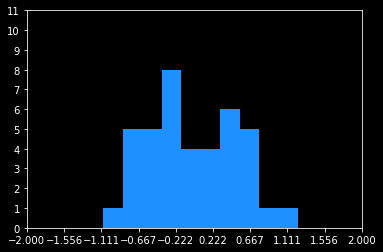

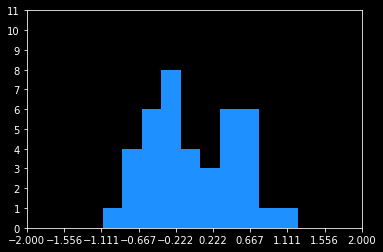

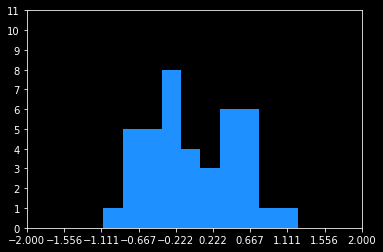

In [67]:
for i in range(len(w3_maml_model)):
    fig = plt.figure(i)
    data = plt.hist(w3_maml_model[i], facecolor='dodgerblue')
    plt.xticks(np.linspace(-2,2,10))
    plt.yticks(np.arange(0,12))
    n ,bin_ = data[0], data[1]
    print('n:\n', n,'\nbin:\n', bin_)
    print('\n bin with most amount', bin_[np.argmax(n)])

n:
 [ 0.  0.  0.  0.  0. 40.  0.  0.  0.  0.] 
bin:
 [-0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5]

 bin with most amount 0.0
n:
 [ 2.  4.  3.  5. 15.  1.  4.  2.  2.  2.] 
bin:
 [-5.94735955e-03 -4.47635286e-03 -3.00534617e-03 -1.53433948e-03
 -6.33327905e-05  1.40767390e-03  2.87868059e-03  4.34968728e-03
  5.82069397e-03  7.29170066e-03  8.76270735e-03]

 bin with most amount -6.333279050005879e-05
n:
 [ 2.  1.  4. 10. 14.  2.  2.  0.  4.  1.] 
bin:
 [-0.00646835 -0.00504687 -0.00362538 -0.0022039  -0.00078242  0.00063906
  0.00206054  0.00348202  0.0049035   0.00632498  0.00774646]

 bin with most amount -0.0007824237226147033


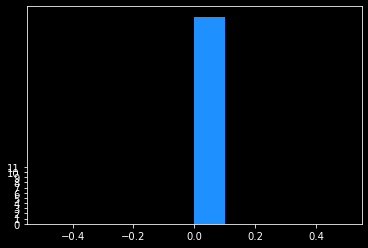

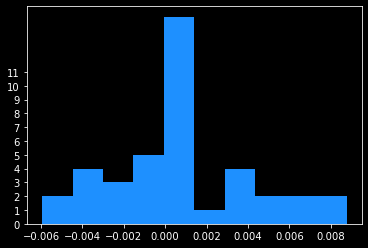

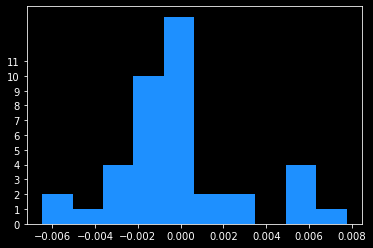

In [68]:
for i in range(len(w3_maml_model)):
    fig = plt.figure(i)
    data = plt.hist(w3_maml - w3_maml_model[i], facecolor='dodgerblue')
#     plt.xticks(np.linspace(-0.1,0.1,10))
    plt.yticks(np.arange(0,12))
    n ,bin_ = data[0], data[1]
    print('n:\n', n,'\nbin:\n', bin_)
    print('\n bin with most amount', bin_[np.argmax(n)])

![alt text](https://miro.medium.com/max/585/1*WmG_R90SyXjWwu6qPfwtQQ.png)